In [85]:
%load_ext autoreload
%autoreload 2

from src.experiment import get_fallacy_df
from src.analysis import score_fallacy_identification, get_fallacy_identification_accuracies
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_theme()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fallacy Identification Analysis

## Experiment 1: Fallacy Identification with zero-shot Prompt

In [86]:
df_fallacies = get_fallacy_df('data/fallacy_identification_zero_shot.csv')

[2024-10-18 10:59:58] Loaded existing fallacy identification dataframe from CSV.


In [87]:
score_fallacy_identification(df_fallacies)

df_fallacies.head()

,step,entity,fallacy,label,category,type,gpt_4o_response,gpt_4_response,gpt_4o_mini_response,claude_3_5_sonnet_response,gemini_1_5_pro_response,gemini_1_5_flash_response,gpt_4_score,gpt_4o_score,gpt_4o_mini_score,claude_3_5_sonnet_score,gemini_1_5_pro_score,gemini_1_5_flash_score,claude_3_opus_response,claude_3_opus_score
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,No,No,1,1,1,1,1,1,No.,1
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,No,No,1,1,1,1,1,1,No.,1
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,No,No,1,1,1,1,1,1,No.,1
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,Yes,No,1,1,1,1,0,1,No.,1
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,No,No,1,1,1,1,1,1,No.,1


In [89]:
df_fallacies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   step                        4640 non-null   object
 1   entity                      4640 non-null   object
 2   fallacy                     4640 non-null   object
 3   label                       4640 non-null   int64 
 4   category                    4640 non-null   object
 5   type                        4640 non-null   object
 6   gpt_4o_response             4640 non-null   object
 7   gpt_4_response              4640 non-null   object
 8   gpt_4o_mini_response        4640 non-null   object
 9   claude_3_5_sonnet_response  4640 non-null   object
 10  gemini_1_5_pro_response     4640 non-null   object
 11  gemini_1_5_flash_response   4640 non-null   object
 12  gpt_4_score                 4640 non-null   Int64 
 13  gpt_4o_score                4640 non-null   Int6

### Overall Scores

In [90]:
df_accuracies = get_fallacy_identification_accuracies(df_fallacies)
df_accuracies = df_accuracies.sort_values('Accuracy', ascending=False)
df_accuracies

,Accuracy
GPT-4,89.8
Gemini 1.5 Pro,88.7
GPT-4o,88.4
GPT-4o Mini,86.9
Claude 3.5 Sonnet,83.6
Gemini 1.5 Flash,83.2
Claude 3 Opus,82.4


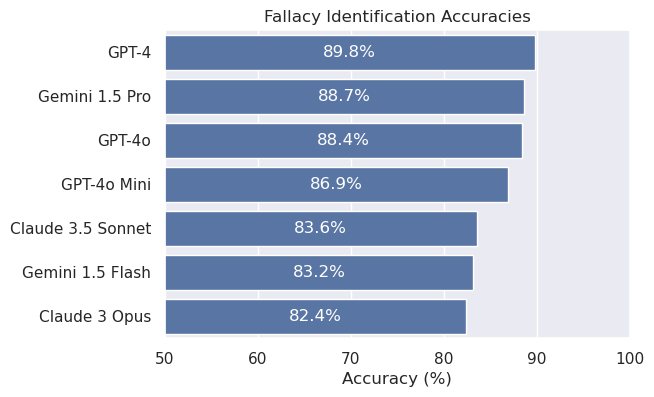

In [110]:
_, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x='Accuracy', y='index', data=df_accuracies.reset_index())
plt.title('Fallacy Identification Accuracies')
plt.xlabel('Accuracy (%)')
plt.ylabel('')

# Set x-axis limits, start from 50% (random guessing)
ax.set_xlim(50, 100)

for i in ax.containers:
    ax.bar_label(i, label_type='center', color='white', fmt='%.1f%%')

plt.show()


### Scores by fallacy category

In [92]:
df_category_accuracies = get_fallacy_identification_accuracies(df_fallacies, ['category'])
df_category_accuracies

,formal,informal
GPT-4,88.3,89.9
GPT-4o,85.6,88.7
GPT-4o Mini,79.6,87.7
Claude 3.5 Sonnet,85.8,83.4
Claude 3 Opus,85.3,81.9
Gemini 1.5 Pro,87.7,88.8
Gemini 1.5 Flash,82.5,83.3


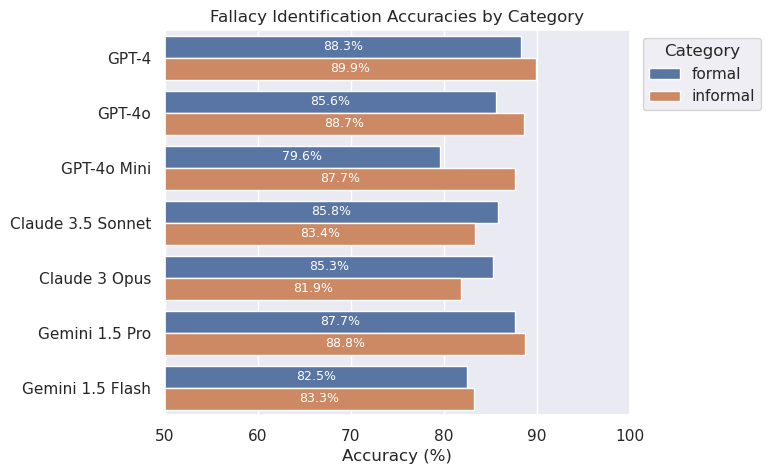

In [108]:
df_category_accuracies_long = pd.melt(df_category_accuracies, var_name='Category', value_name='Accuracy', ignore_index=False)

_, ax = plt.subplots(figsize=(6, 5))
sns.barplot(x='Accuracy', y='index', data=df_category_accuracies_long.reset_index(), 
                 hue='Category', ax=ax)
plt.title('Fallacy Identification Accuracies by Category')
plt.xlabel('Accuracy (%)')
plt.ylabel('')

# Set x-axis limits, start from 50% (random guessing)
ax.set_xlim(50, 100)

for i in ax.containers:
    ax.bar_label(i, label_type='center', color='white', fmt='%.1f%%', fontsize=9)

# Place the legend outside the plot
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), title='Category')

plt.show()

### Scores by fallacy type

In [94]:
df_type_accuracies = get_fallacy_identification_accuracies(df_fallacies, ['category', 'type'])
df_type_accuracies

formal                                             \
                  probabilistic propositional quantificational syllogistic   
GPT-4                      86.2          93.3             84.2        88.8   
GPT-4o                     87.5          83.3             80.8        90.0   
GPT-4o Mini                77.5          80.0             74.2        84.4   
Claude 3.5 Sonnet          81.2          86.7             80.8        91.2   
Claude 3 Opus              72.5          83.0             91.0        87.5   
Gemini 1.5 Pro             88.8          85.0             85.8        90.6   
Gemini 1.5 Flash           76.2          81.7             81.7        86.9   

                   informal                                          \
                  ambiguity inappropriate presumption inconsistency   
GPT-4                  84.7                      86.9          85.0   
GPT-4o                 85.0                      87.0          88.3   
GPT-4o Mini            84.3                      87.0          86.7   
Claude 3.5 Sonnet      78.7                      84.3          81.7   
Claude 3 Opus          84.0                      83.6          85.0   
Gemini 1.5 Pro         85.7                      88.1          80.0   
Gemini 1.5 Flash       80.0                      84.4          81.7   

                                             
                  insufficiency irrelevance  
GPT-4                      94.0        90.2  
GPT-4o                     92.4        87.9  
GPT-4o Mini                91.1        86.3  
Claude 3.5 Sonnet          86.9        81.2  
Claude 3 Opus              85.2        76.2  
Gemini 1.5 Pro             92.1        87.8  
Gemini 1.5 Flash           86.6        80.7

In [95]:
df_formal_type_accuracies = get_fallacy_identification_accuracies(df_fallacies[df_fallacies['category'] == 'formal'], ['type'])
df_formal_type_accuracies

,probabilistic,propositional,quantificational,syllogistic
GPT-4,86.2,93.3,84.2,88.8
GPT-4o,87.5,83.3,80.8,90.0
GPT-4o Mini,77.5,80.0,74.2,84.4
Claude 3.5 Sonnet,81.2,86.7,80.8,91.2
Claude 3 Opus,72.5,83.0,91.0,87.5
Gemini 1.5 Pro,88.8,85.0,85.8,90.6
Gemini 1.5 Flash,76.2,81.7,81.7,86.9


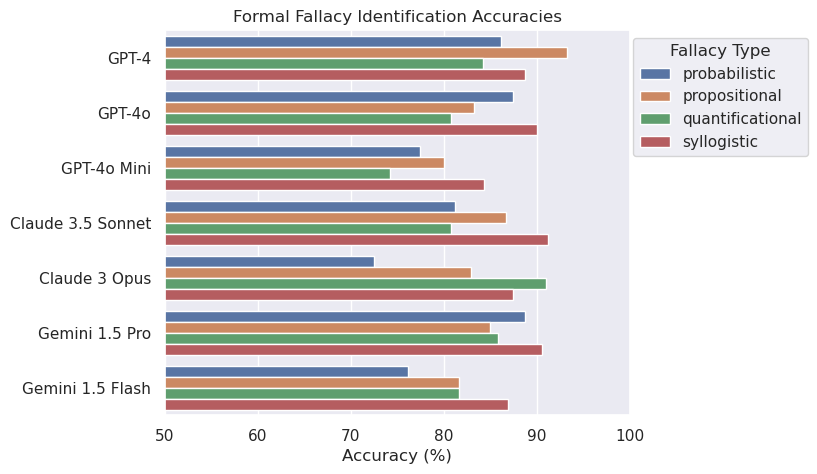

In [107]:
df_formal_type_accuracies_long = pd.melt(df_formal_type_accuracies, var_name='Type', value_name='Accuracy', ignore_index=False)

_, ax = plt.subplots(figsize=(6, 5))
sns.barplot(x='Accuracy', y='index', data=df_formal_type_accuracies_long.reset_index(), 
                 hue='Type', ax=ax)
plt.title('Formal Fallacy Identification Accuracies')
plt.xlabel('Accuracy (%)')
plt.ylabel('')

# Set x-axis limits, start from 50% (random guessing)
ax.set_xlim(50, 100)

# Place the legend outside the plot
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1), title='Fallacy Type')

plt.show()

In [97]:
df_informal_type_accuracies = get_fallacy_identification_accuracies(df_fallacies[df_fallacies['category'] == 'informal'], ['type'])
df_informal_type_accuracies

,ambiguity,inappropriate presumption,inconsistency,insufficiency,irrelevance
GPT-4,84.7,86.9,85.0,94.0,90.2
GPT-4o,85.0,87.0,88.3,92.4,87.9
GPT-4o Mini,84.3,87.0,86.7,91.1,86.3
Claude 3.5 Sonnet,78.7,84.3,81.7,86.9,81.2
Claude 3 Opus,84.0,83.6,85.0,85.2,76.2
Gemini 1.5 Pro,85.7,88.1,80.0,92.1,87.8
Gemini 1.5 Flash,80.0,84.4,81.7,86.6,80.7


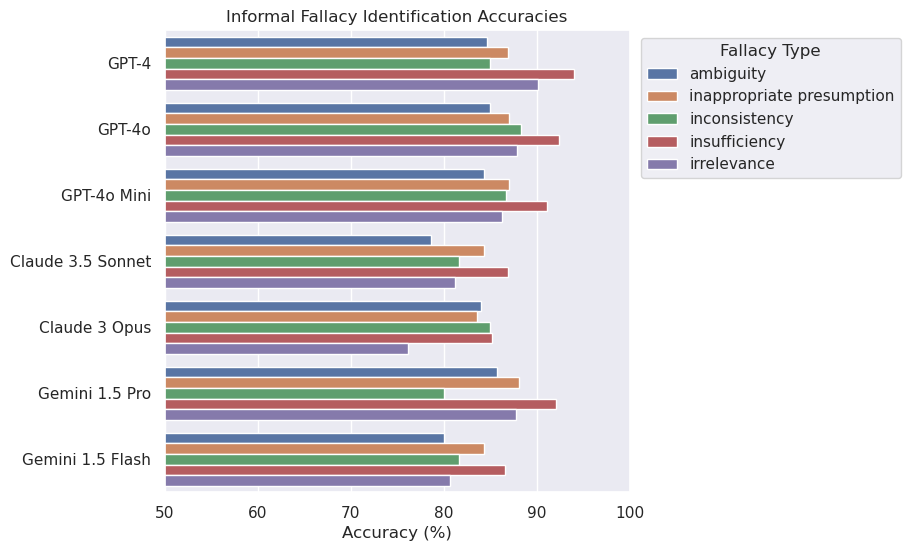

In [105]:
df_informal_type_accuracies_long = pd.melt(df_informal_type_accuracies, var_name='Type', value_name='Accuracy', ignore_index=False)

_, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x='Accuracy', y='index', data=df_informal_type_accuracies_long.reset_index(), 
            hue='Type', ax=ax)
plt.title('Informal Fallacy Identification Accuracies')
plt.xlabel('Accuracy (%)')
plt.ylabel('')

# Set x-axis limits, start from 50% (random guessing)
ax.set_xlim(50, 100)

# Place the legend outside the plot
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1), title='Fallacy Type')

plt.show()